# Machine Learning Challenge

Étudiants :
- MONNIER Raphaël
- PLANCHENAULT Allan
- POINGT Tanguy
- TAROT Bastien

Technique de Machine Learning utilisée pour construire le modèle : Se baser sur les landmarks pour construire le modèle.

## Installation des libraries

In [1]:
%pip install numpy matplotlib pandas scikit-learn keras tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.svm import SVC
import pickle


## Code réutilisable

### Variables globales

In [3]:
emotion_to_number = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "anger": 3,
    "surprise": 4,
    "disgust": 5,
    "fear": 6
}

number_to_emotion = {
    0 : "neutral",
    1 : "happy",
    2 : "sad",
    3 : "anger",
    4 : "surprise",
    5 : "disgust",
    6 : "fear"
}

### Fonctions

In [4]:
def evaluate_model(model, x_test, y_test):
    y_predict = model.predict(x_test)
    accuracy = accuracy_score(y_predict, y_test)
    report = classification_report(y_test, y_predict)
    matrix = confusion_matrix(y_test, y_predict)
    return accuracy, report, matrix

def plot_confusion_matrix(matrix, labels, title='Confusion Matrix'):
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'), horizontalalignment="center", color="white" if matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_metrics(matrix, labels, accuracy, report):
    plt.figure(figsize=(10,5))
    plot_confusion_matrix(matrix, labels)
    plt.show()
    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:\n", report)

def save_model(model, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump({'model': model}, f)

def tune_hyperparameters_svm(X_train, y_train, param_grid):
    svm = SVC(decision_function_shape='ovo')  # ovo: one-vs-one classification for multi-class
    stratified_kfold = StratifiedKFold(n_splits=7)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, verbose=1, scoring='accuracy', error_score='raise', return_train_score=True)
    grid_search.fit(X_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    return grid_search.best_estimator_

def load_model(file_path):
    with open(file_path, 'rb') as f:
        model_data = pickle.load(f)
    return model_data['model']

def plot_image_with_landmarks(image_name, X_x, X_y):
    # Load image
    img = image.imread("./project_data/training_set/" + image_name)
    # Plot image
    plt.imshow(img)
    # Plot landmarks
    plt.scatter(X_x, X_y, c='r', s=10)
    plt.show()

## Exploration des données

In [5]:
# Load CSV file
csv_path = "./project_data/training_set.csv"
data = pd.read_csv(csv_path).values

# Split data into features and labels
X = data[:, 2:]
y = data[:, 1]
image_names = data[:, 0]

# Inside X, there are landmarks coordinates, the first 67 columns are x coordinates, the last 67 columns are y coordinates
X_x = X[:, :68]
X_y = X[:, 68:]

# Print some statistics
print("Data shape", data.shape)
print("X shape", X.shape)
print("y shape", y.shape)
print("There are {} features".format(X.shape[1]))
print("There are {} uniques labels".format(len(np.unique(y))))

Data shape (977, 138)
X shape (977, 136)
y shape (977,)
There are 136 features
There are 7 uniques labels


Nombre d'instances de la classe anger : 149
Nombre d'instances de la classe disgust : 149
Nombre d'instances de la classe fear : 150
Nombre d'instances de la classe happy : 101
Nombre d'instances de la classe neutral : 130
Nombre d'instances de la classe sad : 149
Nombre d'instances de la classe surprise : 149


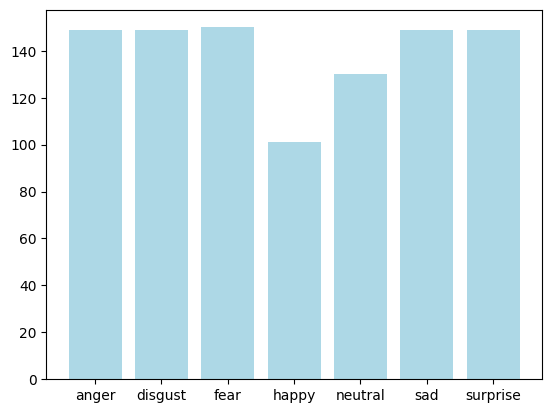

In [6]:
# Plot histogram of labels
effectifs = {i:np.sum(y==i) for i in np.unique(y)}
for k,v in effectifs.items():
  print(f"Nombre d'instances de la classe {k} : {v}")

plt.bar(effectifs.keys(), effectifs.values(), color='lightblue')
plt.show()

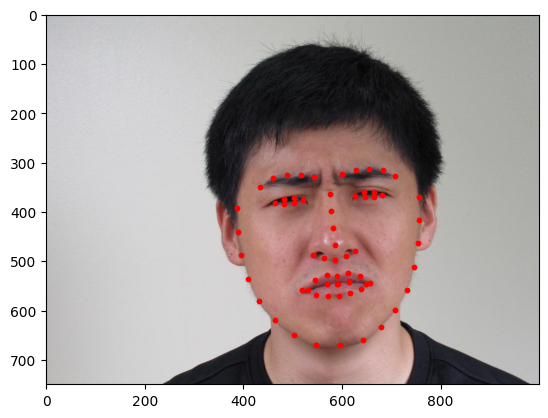

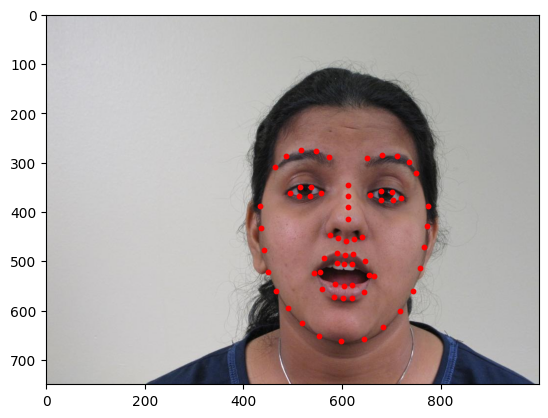

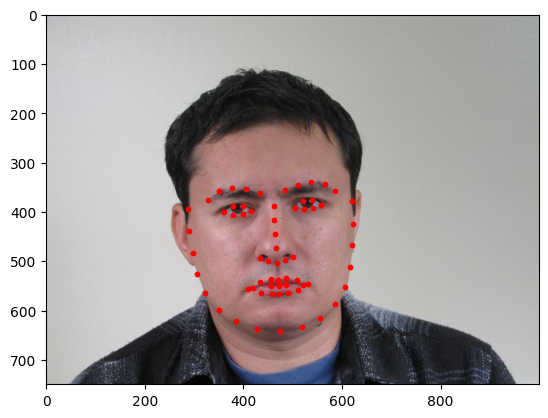

In [7]:
# Plot some image with landmarks
for i in range(3):
    plot_image_with_landmarks(image_names[i], X_x[i], X_y[i])

## Préparation des données

In [8]:
# Convert labels to numbers
y = [emotion_to_number[emotion] for emotion in y]

# Normalize data
X = X.astype(float)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test, image_names_train, image_names_test = train_test_split(X, y, image_names, test_size=0.2)

# Show train distribution
print("Train distribution")
for i in range(7):
    print(f"{number_to_emotion[i]}: {y_train.count(i)}")

Train distribution
neutral: 91
happy: 79
sad: 121
anger: 125
surprise: 125
disgust: 121
fear: 119


## Entraînement du modèle

Fitting 7 folds for each of 64 candidates, totalling 448 fits
Best parameters found:  {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.73


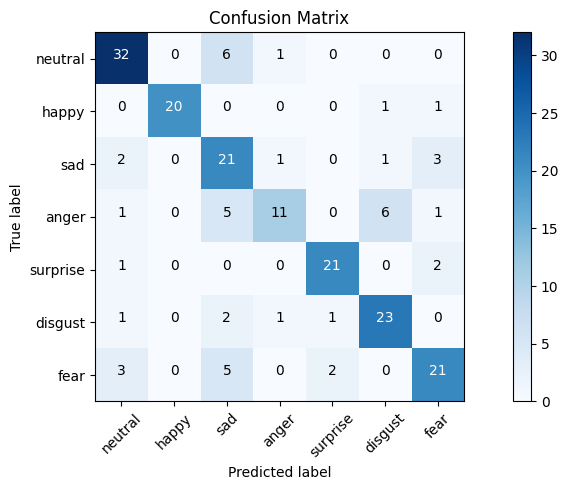

Classification Accuracy: 76.02%

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81        39
           1       1.00      0.91      0.95        22
           2       0.54      0.75      0.63        28
           3       0.79      0.46      0.58        24
           4       0.88      0.88      0.88        24
           5       0.74      0.82      0.78        28
           6       0.75      0.68      0.71        31

    accuracy                           0.76       196
   macro avg       0.78      0.76      0.76       196
weighted avg       0.78      0.76      0.76       196



In [10]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Get best model from grid search
best_model = tune_hyperparameters_svm(X_train, y_train, param_grid)

# Evaluate model
accuracy, report, matrix = evaluate_model(best_model, X_test, y_test)

# Plot metrics
plot_metrics(matrix, list(emotion_to_number.keys()), accuracy, report)

# Save model
save_model(best_model, "svm_model.pkl")

## Test du modèle (dans le cadre du rendu intermédiaire du challenge)

### Chargement des données de test

In [11]:
test_csv_path = "./testing_data/testing_data.csv"
test_image_path = "./testing_data/testing_img/"

# Load the model
svm_model = load_model('svm_model.pkl')

# Load the testing data
test_data = pd.read_csv(test_csv_path).values

# Split data into image names and features
X_test = test_data[:, 1:]
image_names = test_data[:, 0]

### Préparation des données de tests (normalisation, etc.)

In [12]:
# Normalize data
X_test = X_test.astype('float32')
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

### Prédiction des labels

In [13]:
# Predict the labels
y_predict = svm_model.predict(X_test)

# Convert the labels to emotions
y_predict = [number_to_emotion[label] for label in y_predict]

# Save the predictions to a CSV file
results = pd.DataFrame(y_predict, columns=['labels'])
results.to_csv('results.csv', index=False)

Accuracy: 45.00%


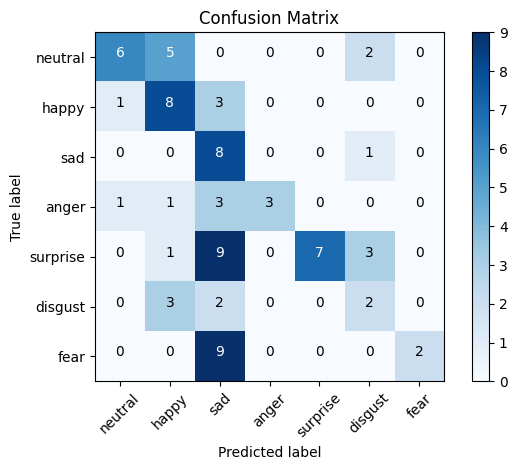

In [14]:
# Compare res.csv and results.csv on column labels
res = pd.read_csv('./testing_data/tests_pseudo_labels.csv')
results = pd.read_csv('results.csv')

# Measure accuracy
accuracy = np.sum(res['labels'] == results['labels']) / len(res['labels'])
print(f"Accuracy: {accuracy*100:.2f}%")

# Plot confusion matrix
matrix = confusion_matrix(res['labels'], results['labels'])
plot_confusion_matrix(matrix, list(emotion_to_number.keys()))
plt.show()